In [1]:
import csv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import re
import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta
import requests
from bs4 import BeautifulSoup
import tweepy
from transformers import pipeline
import yfinance as yf
import time
import re
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [8]:
import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta
import requests
from bs4 import BeautifulSoup
import tweepy
from transformers import pipeline
import yfinance as yf
import time
import re
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')



class IndianNewsCollector:
    """Handles news collection from Indian financial news sources"""
    
    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        })
    
    def scrape_economic_times_news(self):
        """
        Scrape latest market news from Economic Times
        Returns:
            list: List of news articles with metadata
        """
        try:
            url = "https://economictimes.indiatimes.com/markets/stocks/news"
            response = self.session.get(url, timeout=10)
            response.raise_for_status()
            
            soup = BeautifulSoup(response.content, 'html.parser')
            news_items = []
            
            articles = soup.find_all('div', {'class': re.compile('eachStory')}) or \
                      soup.find_all('a', {'class': re.compile('news')})
            
            for article in articles[:15]:
                try:
                    title_elem = article.find('h3') or article.find('h4') or article
                    if title_elem:
                        title = title_elem.get_text(strip=True)
                        link = article.get('href', '') or article.find('a', href=True)
                        
                        if isinstance(link, str) and link:
                            url = link if link.startswith('http') else f"https://economictimes.indiatimes.com{link}"
                        elif link and link.get('href'):
                            url = link['href']
                            url = url if url.startswith('http') else f"https://economictimes.indiatimes.com{url}"
                        else:
                            continue
                        
                        if title and len(title) > 10:
                            news_items.append({
                                'title': title,
                                'url': url,
                                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M'),
                                'source': 'Economic Times',
                                'category': 'Markets'
                            })
                except Exception as e:
                    continue
            
            return news_items
            
        except Exception as e:
            st.warning(f"Could not fetch Economic Times news: {str(e)}")
            return []
    
    def scrape_moneycontrol_news(self):
        """
        Scrape latest market news from Moneycontrol
        Returns:
            list: List of news articles with metadata
        """
        try:
            url = "https://www.moneycontrol.com/news/business/markets/"
            response = self.session.get(url, timeout=10)
            response.raise_for_status()
            
            soup = BeautifulSoup(response.content, 'html.parser')
            news_items = []
            
            articles = soup.find_all('li', {'class': re.compile('clearfix')}) or \
                      soup.find_all('h2') or soup.find_all('a', {'class': re.compile('news')})
            
            for article in articles[:15]:
                try:
                    title_elem = article.find('a') or article
                    if title_elem:
                        title = title_elem.get_text(strip=True)
                        link = title_elem.get('href', '') if hasattr(title_elem, 'get') else ''
                        
                        if link and not link.startswith('http'):
                            link = f"https://www.moneycontrol.com{link}"
                        
                        if title and len(title) > 10 and link:
                            news_items.append({
                                'title': title,
                                'url': link,
                                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M'),
                                'source': 'MoneyControl',
                                'category': 'Markets'
                            })
                except Exception as e:
                    continue
            
            return news_items
            
        except Exception as e:
            st.warning(f"Could not fetch MoneyControl news: {str(e)}")
            return []
    
    def scrape_mint_news(self):
        """
        Scrape latest market news from LiveMint
        Returns:
            list: List of news articles with metadata
        """
        try:
            url = "https://www.livemint.com/market"
            response = self.session.get(url, timeout=10)
            response.raise_for_status()
            
            soup = BeautifulSoup(response.content, 'html.parser')
            news_items = []
            
            articles = soup.find_all('h3') or soup.find_all('h2')
            
            for article in articles[:15]:
                try:
                    title_elem = article.find('a') or article
                    if title_elem:
                        title = title_elem.get_text(strip=True)
                        link = title_elem.get('href', '') if hasattr(title_elem, 'get') else ''
                        
                        if link and not link.startswith('http'):
                            link = f"https://www.livemint.com{link}"
                        
                        if title and len(title) > 10 and link:
                            news_items.append({
                                'title': title,
                                'url': link,
                                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M'),
                                'source': 'LiveMint',
                                'category': 'Markets'
                            })
                except Exception as e:
                    continue
            
            return news_items
            
        except Exception as e:
            st.warning(f"Could not fetch LiveMint news: {str(e)}")
            return []
    
    def get_all_indian_market_news(self):
        """
        Aggregate news from all Indian sources
        Returns:
            list: Combined list of news articles
        """
        all_news = []
        
        sources = [
            self.scrape_economic_times_news,
            self.scrape_moneycontrol_news,
            self.scrape_mint_news
        ]
        
        for source_func in sources:
            try:
                news = source_func()
                all_news.extend(news)
            except Exception as e:
                st.warning(f"Error fetching from {source_func.__name__}: {str(e)}")
                continue
        
        unique_news = []
        seen_titles = set()
        
        for news_item in all_news:
            title_lower = news_item['title'].lower()
            is_duplicate = any(
                self._calculate_similarity(title_lower, seen_title) > 0.8 
                for seen_title in seen_titles
            )
            
            if not is_duplicate:
                unique_news.append(news_item)
                seen_titles.add(title_lower)
        
        return sorted(unique_news, key=lambda x: x['timestamp'], reverse=True)
    
    def _calculate_similarity(self, text1, text2):
        """Calculate similarity between two texts (simple implementation)"""
        words1 = set(text1.split())
        words2 = set(text2.split())
        intersection = words1.intersection(words2)
        union = words1.union(words2)
        return len(intersection) / len(union) if union else 0


In [9]:
class SentimentAnalyzer:
    """Advanced sentiment analysis for financial news and social media"""
    
    def __init__(self):
        self.vader_analyzer = SentimentIntensityAnalyzer()
        
        try:
            self.transformer_analyzer = pipeline(
                "sentiment-analysis",
                model="nlptown/bert-base-multilingual-uncased-sentiment",
                return_all_scores=True
            )
        except Exception as e:
            st.warning("Advanced sentiment model not available, using VADER only")
            self.transformer_analyzer = None
        
        self.bullish_keywords = [
            'bullish', 'rally', 'surge', 'gain', 'rise', 'up', 'positive', 'growth',
            'buying', 'demand', 'strong', 'outperform', 'target', 'upgrade', 'buy',
            'momentum', 'breakout', 'support', 'recovery', 'optimistic', 'profit'
        ]
        
        self.bearish_keywords = [
            'bearish', 'fall', 'decline', 'drop', 'down', 'negative', 'loss', 'weak',
            'selling', 'correction', 'crash', 'resistance', 'downgrade', 'sell',
            'pressure', 'volatility', 'concern', 'risk', 'pessimistic', 'loss'
        ]
    
    def analyze_text_sentiment(self, text):
 
        cleaned_text = self._clean_text(text)
        
        vader_scores = self.vader_analyzer.polarity_scores(cleaned_text)
        
        keyword_sentiment = self._analyze_financial_keywords(cleaned_text)
        
        final_sentiment = {
            'compound': (vader_scores['compound'] + keyword_sentiment) / 2,
            'positive': vader_scores['pos'],
            'negative': vader_scores['neg'],
            'neutral': vader_scores['neu'],
            'keyword_sentiment': keyword_sentiment
        }
        
        if final_sentiment['compound'] >= 0.1:
            final_sentiment['classification'] = 'Bullish'
        elif final_sentiment['compound'] <= -0.1:
            final_sentiment['classification'] = 'Bearish'
        else:
            final_sentiment['classification'] = 'Neutral'
        
        return final_sentiment
    
    def _clean_text(self, text):
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#(\w+)', r'\1', text)  
        text = re.sub(r'\s+', ' ', text).strip()
        return text.lower()
    
    def _analyze_financial_keywords(self, text):
        #check keywords
        bullish_count = sum(1 for word in self.bullish_keywords if word in text)
        bearish_count = sum(1 for word in self.bearish_keywords if word in text)
        
        total_words = len(text.split())
        if total_words == 0:
            return 0
        
        bullish_score = bullish_count / total_words
        bearish_score = bearish_count / total_words
        
        return bullish_score - bearish_score
    
    def analyze_news_batch(self, news_items):

        # analyse sen of news
        analyzed_news = []
        
        for news_item in news_items:
            try:
                sentiment = self.analyze_text_sentiment(news_item['title'])
                news_item.update(sentiment)
                analyzed_news.append(news_item)
            except Exception as e:
                continue
        
        return analyzed_news


In [10]:

df = pd.read_csv(r'data.csv')



if __name__ == "__main__":
    collector = IndianNewsCollector()
    raw_news = collector.get_all_indian_market_news()

    analyzer = SentimentAnalyzer()
    analyzed_news = analyzer.analyze_news_batch(raw_news)

    for news in analyzed_news:
        print(f"\n📰 {news['title']}")
        print(f"🔗 URL: {news['url']}")
        print(f"⏱  Timestamp: {news['timestamp']}")
        print(f"📍 Source: {news['source']}")
        print(f"📂 Category: {news['category']}")
        print(f"📈 Sentiment: {news['classification']} (Score: {news['compound']:.2f})")

    # Step 4: Save to CSV
    with open('data.csv', 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = [
            'title', 'url', 'timestamp', 'source', 'category',
            'compound', 'positive', 'negative', 'neutral', 'keyword_sentiment', 'classification'
        ]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(analyzed_news)

    print("\n✅ Analyzed news saved to data.csv")


Device set to use cpu



📰 Will consumer stocks see a comeback this festive season? 12 stocks to keep an eye on even when analysts are not bullish
🔗 URL: https://economictimes.indiatimes.com/markets/stocks/news/will-consumer-stocks-see-a-comeback-this-festive-season-12-stocks-to-keep-an-eye-on-even-when-analysts-are-not-bullish/articleshow/122797405.cms
⏱  Timestamp: 2025-07-20 17:58
📍 Source: Economic Times
📂 Category: Markets
📈 Sentiment: Bullish (Score: 0.29)

📰 How global forces are reshaping base metal prices
🔗 URL: https://economictimes.indiatimes.com/markets/stocks/news/how-global-forces-are-reshaping-base-metal-prices/articleshow/122797289.cms
⏱  Timestamp: 2025-07-20 17:58
📍 Source: Economic Times
📂 Category: Markets
📈 Sentiment: Neutral (Score: 0.00)

📰 Apollo Tyres, Brigade Enterprises among 10 small-cap stocks trading below industry PE; may rally up to 43%
🔗 URL: https://economictimes.indiatimes.com/markets/stocks/news/apollo-tyres-brigade-enterprises-among-10-small-cap-stocks-trading-below-indust

classification
Bullish    13
Neutral    12
Bearish     3
Name: count, dtype: int64


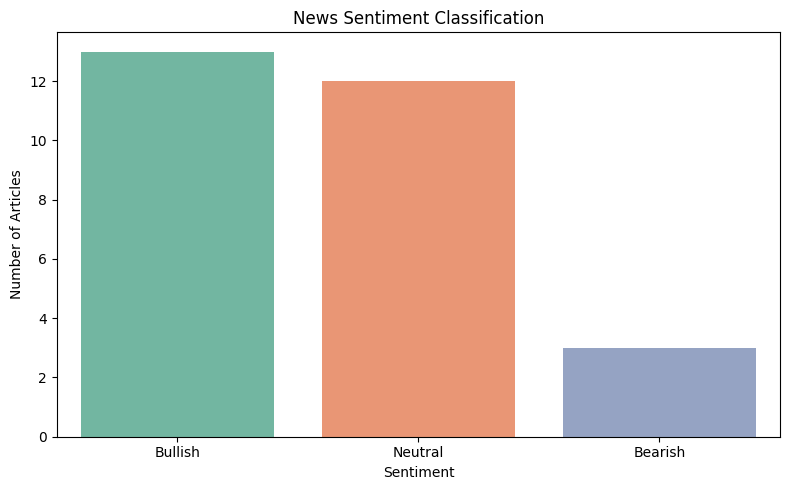

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV
df = pd.read_csv('data.csv')

# Display count of each sentiment class
print(df['classification'].value_counts())

# Plot a bar chart for sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='classification', palette='Set2')
plt.title('News Sentiment Classification')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()


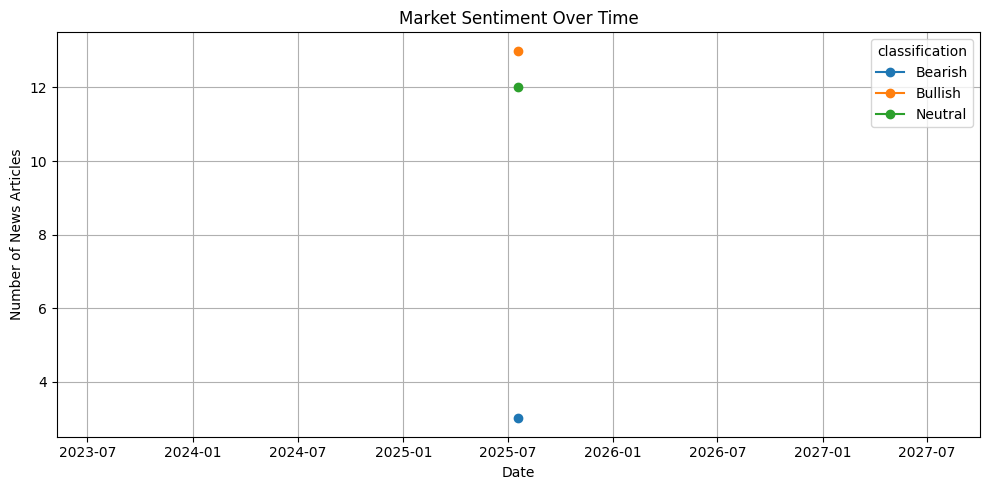

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Group by date and sentiment
df['date'] = df['timestamp'].dt.date
sentiment_over_time = df.groupby(['date', 'classification']).size().unstack().fillna(0)

# Plot
sentiment_over_time.plot(kind='line', figsize=(10, 5), marker='o')
plt.title('Market Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Number of News Articles')
plt.grid(True)
plt.tight_layout()
plt.show()
